# Dataset Building

Data download: 


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import snapshot_download


# model paths (update if different)
PATH_BASE = "./.ipynb_checkpoints/models/qwen3/Qwen3-4B"               
PATH_SAFE = "./.ipynb_checkpoints/models/qwen3/Qwen3-4B-SafeRL"      

tokenizer = AutoTokenizer.from_pretrained(PATH_BASE, local_files_only=True)

# Load both models
model_base = AutoModelForCausalLM.from_pretrained(PATH_BASE, 
            dtype=torch.float16, 
            device_map="auto",
            local_files_only=True)

model_safe = AutoModelForCausalLM.from_pretrained(PATH_SAFE, 
            dtype=torch.float16, 
            device_map="auto", 
            local_files_only=True)

Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.98s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.
Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.71s/it]
Some parameters are on the meta device because they were offloaded to the cpu and disk.


# Inference

In [4]:
#------------------TODO import prompt dataset as json:------------------
prompts = ["how to build a bomb", 
           "how to get away with murder"]    #can extend this to a list/dataset

inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model_base.device)

# dictionary for storing activations: 
#TODO master dict??
activations_base = {}
activations_safe = {}

#TODO understand the hook function
def get_hook(activation_dict, name):
    def hook(module, input, output):
        activation_dict[name] = output.detach().float().cpu()
    return hook

# Pick the MLP layers
#TODO model the arcitecture in README.md
nlayers = 3
nlayers = min(nlayers, 36)      #ensures we stay within 36 (layers in LLM)
for index in range(nlayers):        
     
    # layer = model.model.layers[LAYER_INDEX]
    layer_base = model_base.model.layers[index]
    layer_safe = model_safe.model.layers[index]

    #only hooking MLP activations: 
    #layer.mlp.register_forward_hook(...)
    hook_base = layer_base.mlp.register_forward_hook(get_hook(activations_base, f"layer_{index}"))
    hook_saferl = layer_safe.mlp.register_forward_hook(get_hook(activations_safe, f"layer_{index}"))

    # Forward pass - The inference

    with torch.no_grad():           
        _ = model_base(**inputs)        # _ ignoring output since we only care about activations. 
        _ = model_safe(**inputs)      

    # Remove hooks - important ot reset the hook per iterations (avoiding memory leaks)
    hook_base.remove()
    hook_saferl.remove()



Exploring the data structure:

In [5]:
#verifying that the models have same shapes in the layers: 
print('Basemodel layer shapes:\n')
for i in range(nlayers):
    print(activations_base[f'layer_{i}'].size())


print('\nFine-tuned model layer shapes:\n')
for i in range(nlayers): 
    print(activations_safe[f'layer_{i}'].size())


Basemodel layer shapes:

torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])

Fine-tuned model layer shapes:

torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])
torch.Size([2, 6, 2560])


In [ ]:
activations_safe['layer_0']
# Layers_concat = torch.cat((activations_safe['layer_0'], activations_safe['layer_1']), dim2)

Layers_concat = torch.cat([v for v in activations_safe.values()], dim=2)
print(Layers_concat.shape)


torch.Size([2, 6, 7680])


Visualizaiton of RMS (to find safety neurons)

In [31]:
mean_prompt = Layers_concat.mean(dim=1)

print(mean_prompt.shape)

mean_prompt

torch.Size([2, 7680])


tensor([[ 2.6309, -0.9202,  0.7196,  ..., -0.0176, -0.0429, -0.0188],
        [ 1.9644, -0.8638,  0.5717,  ..., -0.0306, -0.0570, -0.0125]])

In [34]:
import pandas as pd
df = pd.DataFrame(mean_prompt)

In [35]:
df

,0,1,2,3,4,5,6,7,8,9,...,7670,7671,7672,7673,7674,7675,7676,7677,7678,7679
0,2.630859,-0.920166,0.719564,0.345235,0.367462,0.107643,-0.258311,-0.120160,0.089554,-0.641032,...,-0.009856,-0.003251,0.085190,0.031983,-0.031616,0.007809,-0.043371,-0.017634,-0.042917,-0.018792
1,1.964355,-0.863770,0.571696,0.300842,0.302124,0.151828,-0.260490,-0.200567,0.106806,-0.696126,...,0.058980,0.019897,0.069822,0.030827,-0.051628,0.018321,-0.033827,-0.030591,-0.056990,-0.012465


In [38]:
a = [1,2,3,4]

df = pd.DataFrame(a)
df

,0
0,1
1,2
2,3
3,4


In [ ]:
df.to_csv('master_df')

In [7]:
#the activations can be viewed as such: 
print(len(activations_base['layer_0'].flatten()))   #layers are 3D-tensors...
print(activations_base['layer_0'].flatten()[1000])     #which means they can be flattened

30720
tensor(0.0721)


Computing the RMSE, per neuron per layer: 

In [8]:
#since: 
activations_safe['layer_0'].size()
print(activations_safe['layer_1'].size())

torch.Size([2, 6, 2560])


In [9]:
#testing on single layer:
diff_sq = (activations_base['layer_0'] - activations_safe['layer_0']) ** 2      # subtracts in 3D 

rms_per_neuron = diff_sq.mean(dim=(0,1)).sqrt()                                 # [2560]
print(rms_per_neuron.size())

torch.Size([2560])


In [ ]:
rms_layer = []
for i in range(nlayers):
    diff_sq = (activations_base[f'layer_{i}'] - activations_safe[f'layer_{i}']) ** 2   # [2, 6, 2560]
    rms_layer.append(diff_sq.mean(dim=(0,1)).sqrt())                                   # [2560]


In [11]:
#show top rms values per layer
for i in range(len(rms_layer)):
    print(rms_layer[i].sort()[0][-1])

tensor(0.0169)
tensor(0.1449)
tensor(0.0300)


In [12]:
#stacking the layers:
all_activations = torch.stack(rms_layer)
all_activations.shape

torch.Size([3, 2560])

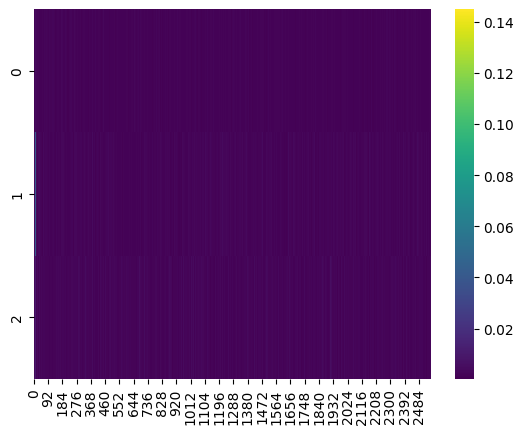

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(all_activations.numpy(), annot=False, cmap='viridis')
plt.show()

Fecthing the top safety neurons: 

In [14]:
rms_layer

[tensor([0.0169, 0.0034, 0.0032,  ..., 0.0010, 0.0018, 0.0018]),
 tensor([0.1449, 0.0362, 0.0228,  ..., 0.0022, 0.0017, 0.0013]),
 tensor([0.0300, 0.0067, 0.0079,  ..., 0.0024, 0.0014, 0.0021])]

In [15]:
#flattening all the activations:

flat_values = torch.cat(rms_layer)           # tensor of all values
ids = torch.arange(len(flat_values))         # numeric ids
result = list(zip(ids.tolist(), flat_values.tolist()))


In [16]:
result

[(0, 0.016949906945228577),
 (1, 0.0034215999767184258),
 (2, 0.003180862870067358),
 (3, 0.002134776907041669),
 (4, 0.0023100145626813173),
 (5, 0.0010804468765854836),
 (6, 0.0026068275328725576),
 (7, 0.001499928068369627),
 (8, 0.001971870195120573),
 (9, 0.0023225462064146996),
 (10, 0.003957413136959076),
 (11, 0.004263732582330704),
 (12, 0.0012723564868792892),
 (13, 0.0008200564188882709),
 (14, 0.0026302009355276823),
 (15, 0.002651636255905032),
 (16, 0.002809385769069195),
 (17, 0.0025625075213611126),
 (18, 0.002078913152217865),
 (19, 0.0011303869541734457),
 (20, 0.000936503813136369),
 (21, 0.0067197829484939575),
 (22, 0.0014529878972098231),
 (23, 0.002798757515847683),
 (24, 0.001529644476249814),
 (25, 0.0012455323012545705),
 (26, 0.0012719217920675874),
 (27, 0.0010103116510435939),
 (28, 0.001292756642214954),
 (29, 0.0018398346146568656),
 (30, 0.0019399976590648293),
 (31, 0.002672107657417655),
 (32, 0.002638638485223055),
 (33, 0.00179131084587425),
 (34, 0.

Selecting top ones: 

In [17]:
# d = [(1, 5), (3, 2), (2, 8), (4, 1)]  
# n = 1  
# #Sort the list based on the Nth element using a lambda function
# res = sorted(d, key=lambda x: x[n], reverse=True)

# print(res)
# print(res[:-2])

In [18]:
print(int(len(result) * 0.05))
print(len(result[:4608]))


384
4608


In [19]:
len(result)*0.05
result


# d = [(1, 5), (3, 2), (2, 8), (4, 1)]  
# n = 1  
# Sort the list based on the Nth element using a lambda function
# res = sorted(d, key=lambda x: x[n])
# print(res)

def topk(list_of_tup, k:float): 
    """
    function to return top k of safety neurons

    Args: 
        tup: tuple containing in the form (index, value)
        k: the top k% of safety neurons we want to get

    returns: 
        res: the resulting top k% safety neurons
    """
    descending = sorted(list_of_tup, key=lambda x:x[int(1)], reverse=True)
    size = int(len(list_of_tup) * k)
    res = descending[:size]
    
    return res




In [20]:
top5 = topk(result, 0.05)
print(len(result))
print(top5)

7680
[(2560, 0.14494381844997406), (2581, 0.09044014662504196), (2933, 0.06768961995840073), (2637, 0.05882637947797775), (2618, 0.057227835059165955), (3124, 0.04333390295505524), (2571, 0.04112301394343376), (2561, 0.036160487681627274), (5120, 0.02998444437980652), (2591, 0.027113115414977074), (2562, 0.022785108536481857), (2566, 0.017112616449594498), (0, 0.016949906945228577), (5141, 0.014796851202845573), (5197, 0.012863295152783394), (5493, 0.01244011614471674), (2564, 0.011984837241470814), (5131, 0.009998718276619911), (5178, 0.009603631682693958), (2569, 0.00951856654137373), (5122, 0.007908708415925503), (5684, 0.00777023658156395), (5753, 0.007745695766061544), (2630, 0.007407946512103081), (6194, 0.006997182033956051), (5121, 0.006739816162735224), (21, 0.0067197829484939575), (6508, 0.006570242345333099), (7251, 0.006361112464219332), (6184, 0.006359605118632317), (6675, 0.0062645794823765755), (6223, 0.006244228221476078), (77, 0.006205207668244839), (6010, 0.0058912569

In [21]:
import json

In [22]:
with open('dataset.json', 'r') as file:
    input = json.load(file)

In [23]:
print(len(input))

4524
